# <center> Residential Power Usage (3 years data) </center>
----
Data obtained from: https://www.kaggle.com/datasets/srinuti/residential-power-usage-3years-data-timeseries?select=power_usage_2016_to_2020.csv

Goals:
- Analyze residential power usage trend
- Study the residential power usage and weather relationship
- Forecast residential power usage 






In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import statistics as stat

from plotly.subplots import make_subplots
from inflection import underscore
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf


In [3]:
##### Functions used in notebook

def dataframe_summary(dataframe: pd.DataFrame,
                      max_length: int):
    
    pd.options.display.float_format = '{:,.4f}'.format

    ### Get list of column names
    col_names = dataframe.columns.to_list()

    ### Get unique count of each column
    col_length = [len(dataframe[val].unique()) for val in col_names]

    ### Append info for dataframe
    col_names.append("this_df")
    col_length.append(len(dataframe))

    ### Create new dataframe for summary
    summary_df = pd.DataFrame(list(zip(col_names, col_length)), columns=["column_name", "unique_count"])
    summary_df["uniqueness"] = summary_df["unique_count"]/len(dataframe) * 100

    ### Count nan values in each column
    nan_df = dataframe.isnull().sum(axis = 0).to_frame().reset_index().rename(columns={"index":"column_name", 0:"nan_count"})
    nan_df["nan_percent"] = nan_df["nan_count"]/len(dataframe)*100
    nan_df["percent_complete"] = 100 - nan_df["nan_percent"]

    ### Create new frame for data type in each column
    type_df = dataframe.dtypes.to_frame().reset_index().rename(columns={"index":"column_name", 0:"data_type"})
    type_df["data_type"] = type_df["data_type"].astype(str)

    ### Create new dataframe with unique entries for each column

    col_name = []
    unique_val = []
    
    for val  in dataframe.columns.to_list():

        col_name.append(val)

        if len(dataframe[val].unique())<=max_length:
            unique_val.append(list(dataframe[val].unique()))

        else:
            unique_val.append(f">{max_length} entries")

    unique_df = pd.DataFrame(list(zip(col_name, unique_val)),
                             columns=["column_name", "unique_entries"])
    
    

    ### Merge summary_df with nan_df, type_df
    summary_df = summary_df.merge(nan_df, on="column_name", how="outer")
    summary_df = summary_df.merge(type_df, on="column_name", how="outer")
    summary_df = summary_df.merge(unique_df, on="column_name", how="outer")


    return summary_df.sort_values(["data_type", "nan_count"])





---
# Import data and change the column names case

---

In [4]:
power_df = pd.read_csv("power_usage_2016_to_2020.csv")
power_df.columns = [underscore(val) for val in power_df.columns]

weather_df = pd.read_csv("weather_2016_2020_daily.csv")
weather_df.columns = [underscore(val) for val in weather_df.columns]


----
# Data Wrangling

---

In [5]:
##### convert column to specific type
power_df["start_date"] = pd.to_datetime(power_df["start_date"])
power_df["power_date"] = power_df["start_date"].dt.date

weather_df["date"] = pd.to_datetime(weather_df["date"])
weather_df = weather_df.rename(columns={"date":"weather_date"})

##### sort data according to date
power_df = power_df.sort_values("power_date")
weather_df = weather_df.sort_values("weather_date")

##### some power usage based on date
daily_power = power_df.groupby("power_date").sum(numeric_only=True).asfreq(freq="1d").reset_index()
daily_power["power_date"] = pd.to_datetime(daily_power["power_date"])
daily_power["day_name"] = daily_power["power_date"].dt.day_name()
daily_power["power_day"] = daily_power["power_date"].dt.day
daily_power["month"] = daily_power["power_date"].dt.month
daily_power["year"] = daily_power["power_date"].dt.year
daily_power["week"] = [daily_power.loc[val, "power_date"].week for val in range(len(daily_power))]
daily_power

##### modification on weather_df
weather_df = weather_df.set_index("weather_date").asfreq(freq="1d").reset_index()
weather_df["weather_date"] = pd.to_datetime(weather_df["weather_date"])
weather_df.loc[:, "day"] = weather_df["weather_date"].dt.day


##### join daily_power and weather_df
power_weather = weather_df.merge(daily_power[["value (k_wh)", "power_date", "day_name", "month", "week", "year"]], 
                                 left_on="weather_date", right_on="power_date", how="right")


###### select data from July 1, 2016 to June 30, 2020
######  - a lot of missing data for power_date < 2016-07-01 and power_date >= 2016-07-01
###### drop these data
power_weather = power_weather[(power_weather["power_date"]>="2016-07-01") & (power_weather["power_date"]<="2020-06-30")]

##### fill NaN data with some values
##### these are applicable to some rows between 2016-07-01 and 2020-06-30
power_weather = power_weather.fillna(power_weather.rolling(7,min_periods=1, center=True).mean(numeric_only=True))




---
# Time Plots

---


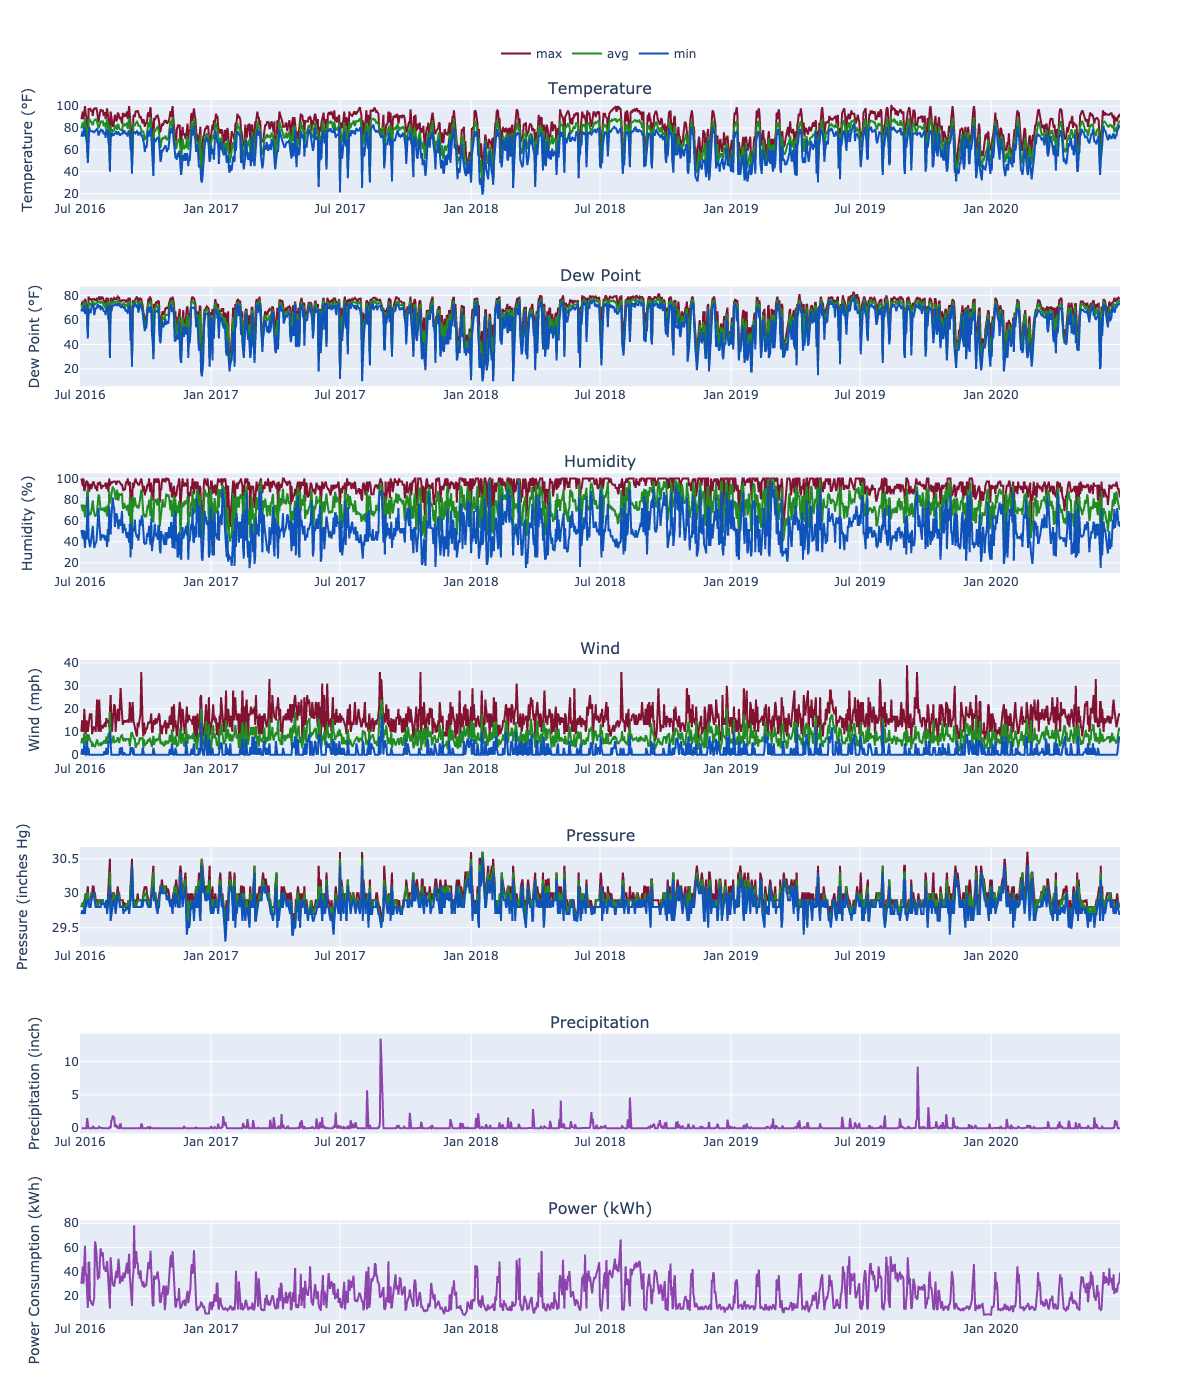

In [7]:
power_weather_cols = ['temp_max', 'temp_avg', 'temp_min', 'dew_max', 'dew_avg', 'dew_min', 'hum_max', 'hum_avg', 'hum_min',
                      'wind_max', 'wind_avg', 'wind_min', 'press_max', 'press_avg', 'press_min', 'precipit', 'value (k_wh)',]

fig_1 = make_subplots(rows=7, cols=1, 
                      subplot_titles=["Temperature", "Dew Point", "Humidity", "Wind", "Pressure",
                                      "Precipitation", "Power (kWh)"])

ind = 0
col_n = ""

color_dict = {"min": "#0F52BA", "avg": "#228B22", "max": "#811331", "others": "#8E44AD"}


for ii in range(len(power_weather_cols)):

    col = power_weather_cols[ii]
    col_split = col.split("_")

    if (len(col_split)>1) and (col_split[1] in color_dict.keys()):
        color = color_dict[col_split[1]]
        group_title = col_split[1]
    else:
        color = color_dict["others"]
        group_title = col


    if col_n != col_split[0]:
        col_n = col_split[0]
        ind = ind + 1

        fig_1.add_trace(
            go.Scatter(x=power_weather["weather_date"], y=power_weather[col], 
                       line=dict(color=color), showlegend=True if (ii<3) else False,
                       legendgroup=group_title, name=group_title
                       ),
            row=ind,
            col=1
        )
    
    else:

        fig_1.add_trace(
            go.Scatter(x=power_weather["weather_date"], y=power_weather[col], 
                       line=dict(color=color), showlegend=True if (ii<3) else False,
                       legendgroup=group_title, name=group_title
                       ),
            row=ind,
            col=1
        )


fig_1.update_yaxes(title_text="Temperature (\xb0F)", row=1)
fig_1.update_yaxes(title_text="Dew Point (\xb0F)", row=2)
fig_1.update_yaxes(title_text="Humidity (%)", row=3)
fig_1.update_yaxes(title_text="Wind (mph)", row=4)
fig_1.update_yaxes(title_text="Pressure (inches Hg)", row=5)
fig_1.update_yaxes(title_text="Precipitation (inch)", row=6)
fig_1.update_yaxes(title_text="Power Consumption (kWh)", row=7)


fig_1.update_layout(height=1400, width=1200,
                    legend=dict(yanchor="top", y=1.05, xanchor="left", x=0.4, orientation="h"))
fig_1.show(renderer="png")



---
# Average (or Sum) of Power Consumptions at Different Granularity

---

In [9]:
"""
grouping at different granularity: hourly, daily, weekly, monthly, and yearly
* hourly: take average directly since the data are already at hourly granularity
* daily: sum the hourly data according to date, followed by average by day
* weekly: sum the daily data into weekly data then average by week
* monthly: sum the daily data into monthly data, then average by month
* yearly: sum to the daily data into yearly data
"""

hourly_average = power_df[["start_date", "value (k_wh)"]].copy()
hourly_average.loc[:, "hour"] = hourly_average["start_date"].dt.hour
hourly_average = hourly_average.groupby("hour").mean().reset_index()

daily_average = power_weather[["day", "value (k_wh)"]].groupby("day").mean(numeric_only=True).reset_index()
daily_average

daily_name_average = power_weather[["day_name", "value (k_wh)"]].groupby("day_name").mean(numeric_only=True)
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_name_average = daily_name_average.reindex(day_names).reset_index()
daily_name_average

weekly_average = daily_power.groupby(["year", "month", "week"]).sum(numeric_only=True).reset_index()
weekly_average = weekly_average[["week", "value (k_wh)"]].groupby("week").mean().reset_index()
weekly_average

monthly_average = daily_power.groupby(["year", "month"]).sum(numeric_only=True).reset_index()
monthly_average = monthly_average[["month", "value (k_wh)"]].groupby("month").mean().reset_index()
monthly_average

yearly_average = daily_power.groupby(["year"]).sum(numeric_only=True).reset_index()
yearly_average



,year,value (k_wh),day_of_week,power_day,month,week
0,2016,6649.682600,15312.0,5752,2379,9592
1,2017,6733.161951,26352.0,5738,2382,9698
2,2018,8051.672900,26208.0,5738,2382,9647
3,2019,7272.962833,26232.0,5738,2382,9647
4,2020,3348.443429,13656.0,5292,2084,8573


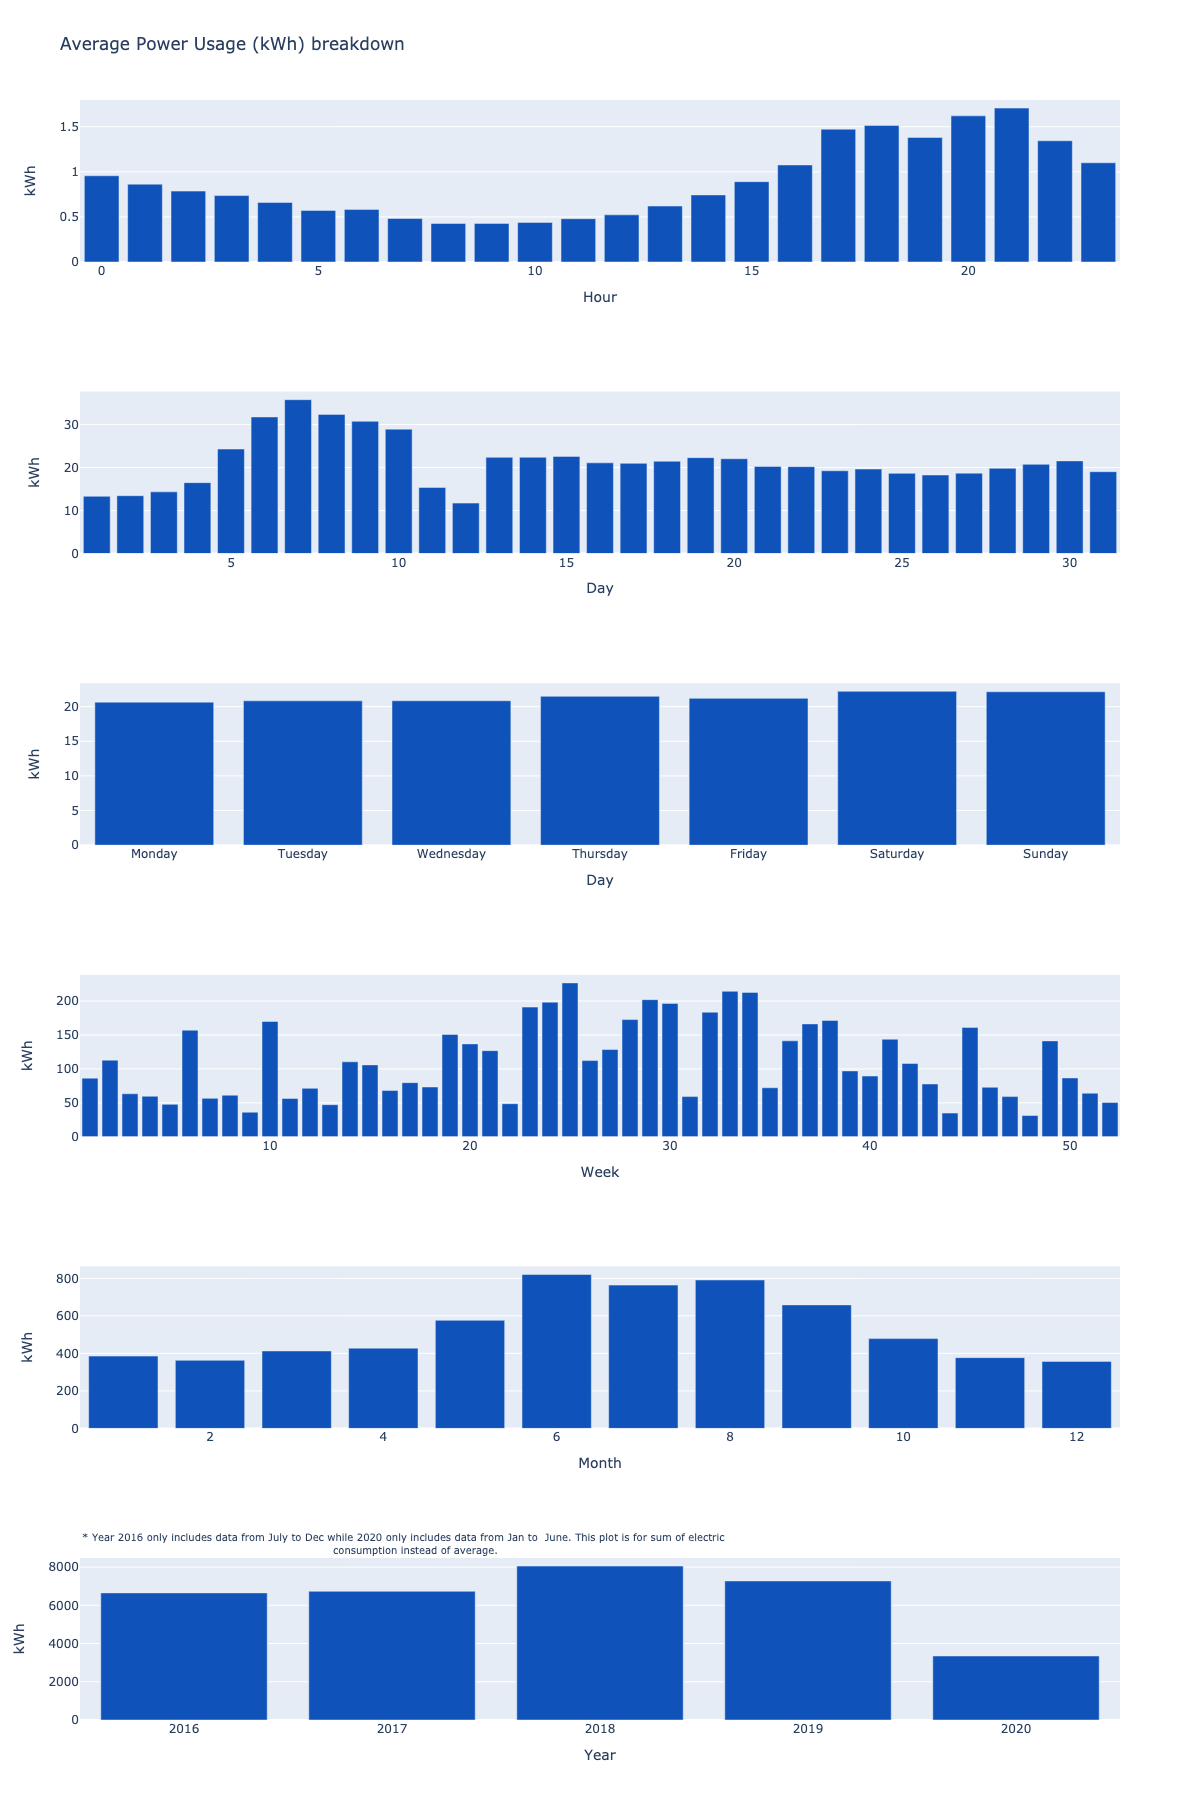

In [10]:
fig_1 = make_subplots(rows=6, cols=1, vertical_spacing=0.08)

fig_1.add_trace( go.Bar(x=hourly_average["hour"], y=hourly_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=1, col=1)

fig_1.add_trace( go.Bar(x=daily_average["day"], y=daily_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=2, col=1)

fig_1.add_trace( go.Bar(x=daily_name_average["day_name"], y=daily_name_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=3, col=1)

fig_1.add_trace( go.Bar(x=weekly_average["week"], y=weekly_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=4, col=1)

fig_1.add_trace( go.Bar(x=monthly_average["month"], y=monthly_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=5, col=1)

fig_1.add_trace( go.Bar(x=yearly_average["year"], y=yearly_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=6, col=1)



fig_1.update_xaxes(title_text="Hour", row=1)
fig_1.update_xaxes(title_text="Day", row=2)
fig_1.update_xaxes(title_text="Day", row=3)
fig_1.update_xaxes(title_text="Week", row=4)
fig_1.update_xaxes(title_text="Month", row=5)
fig_1.update_xaxes(title_text="Year", row=6)

fig_1.update_yaxes(title_text="kWh")


fig_1.update_layout(height=1200, width=800, showlegend=False, title_text="Average Power Usage (kWh) breakdown")
fig_1.add_annotation(
    text="""* Year 2016 only includes data from July to Dec while 2020 only includes data from Jan to  June. This plot is for sum of electric 
    <br> consumption instead of average.""",
    font=dict(size=10),
    xref="paper", yref="paper",
    x=0, y=0.1,
    showarrow=False
)

fig_1.update_layout(height=1800, width=1200)
fig_1.show(renderer="png")



At hourly level, the average power consumption is the highest in the evening between 5 pm to 11 pm. This might be cause by people are back in their home after and they have their daily activities such as cooking, watching tv, and doing laundry. The power consumption starts to go down from 10 pm onwards presumably because people are starting to go to bed.

At daily level, there's a peak power consumption 6th to 8th day of the month. This peak is currently still under investigation. If the average power consumption was taken based on the name of the day, there's no peak appeared, which indicates that the amount of power consume during the week stays relatively the same.

At weekly level, there were apparent patterns in the power consumption. The huge power consumptions at 6th, 10th, 25th, and others are still under investigation.

At monthly level, the power consumption was the highest between June and August. This observation could be realted to the summer months where the temperatures are high. Consequently, people will consume a lot of power to cool down their house.

---
# Power Consumption and Weather Correlation

---

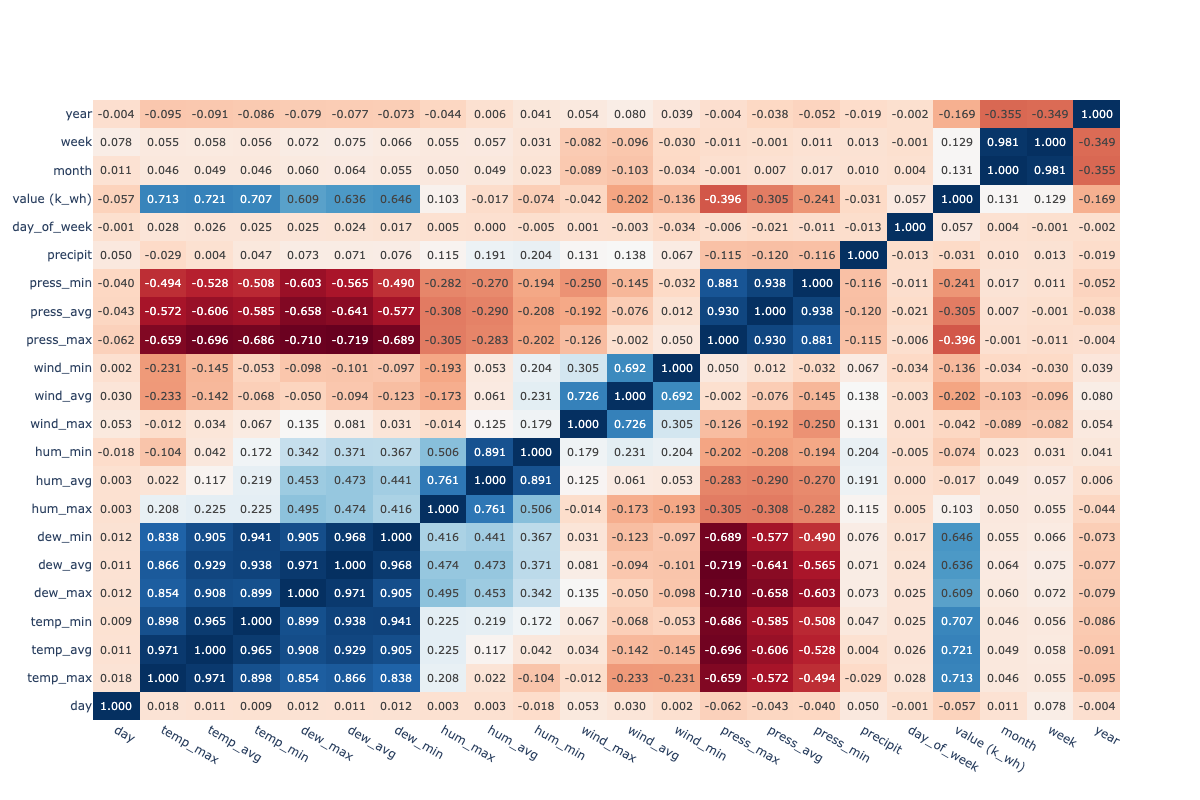

In [13]:
power_weather_corr = power_weather.corr(numeric_only=True)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Heatmap(x=power_weather_corr.columns, y=power_weather_corr.index, 
                         z=power_weather_corr, text=power_weather_corr, texttemplate="%{text:,.3f}",
                         colorscale="RdBu",
                         colorbar=dict(tickvals=[0,1], ticktext=["min", "max"], len=0.5),
                         showscale=False
                         ),
            row=1, col=1)

fig.update_layout(height=800, width=1200)
fig.show(renderer="png")

The heatmap above shows the correlation between power consumption and weather data. As can be seen in the bottom left of the heatmap, the power consumption (value (k_wh)) are positively correlated to the temperatures. The correlation between power consumption and temperatures can be as high as 0.721 between power consumption and average temperature. Power consumption is negatively correlated to pressures, and this correlation can be as high as -0.396 between power consumption and max pressure recorded in a day.

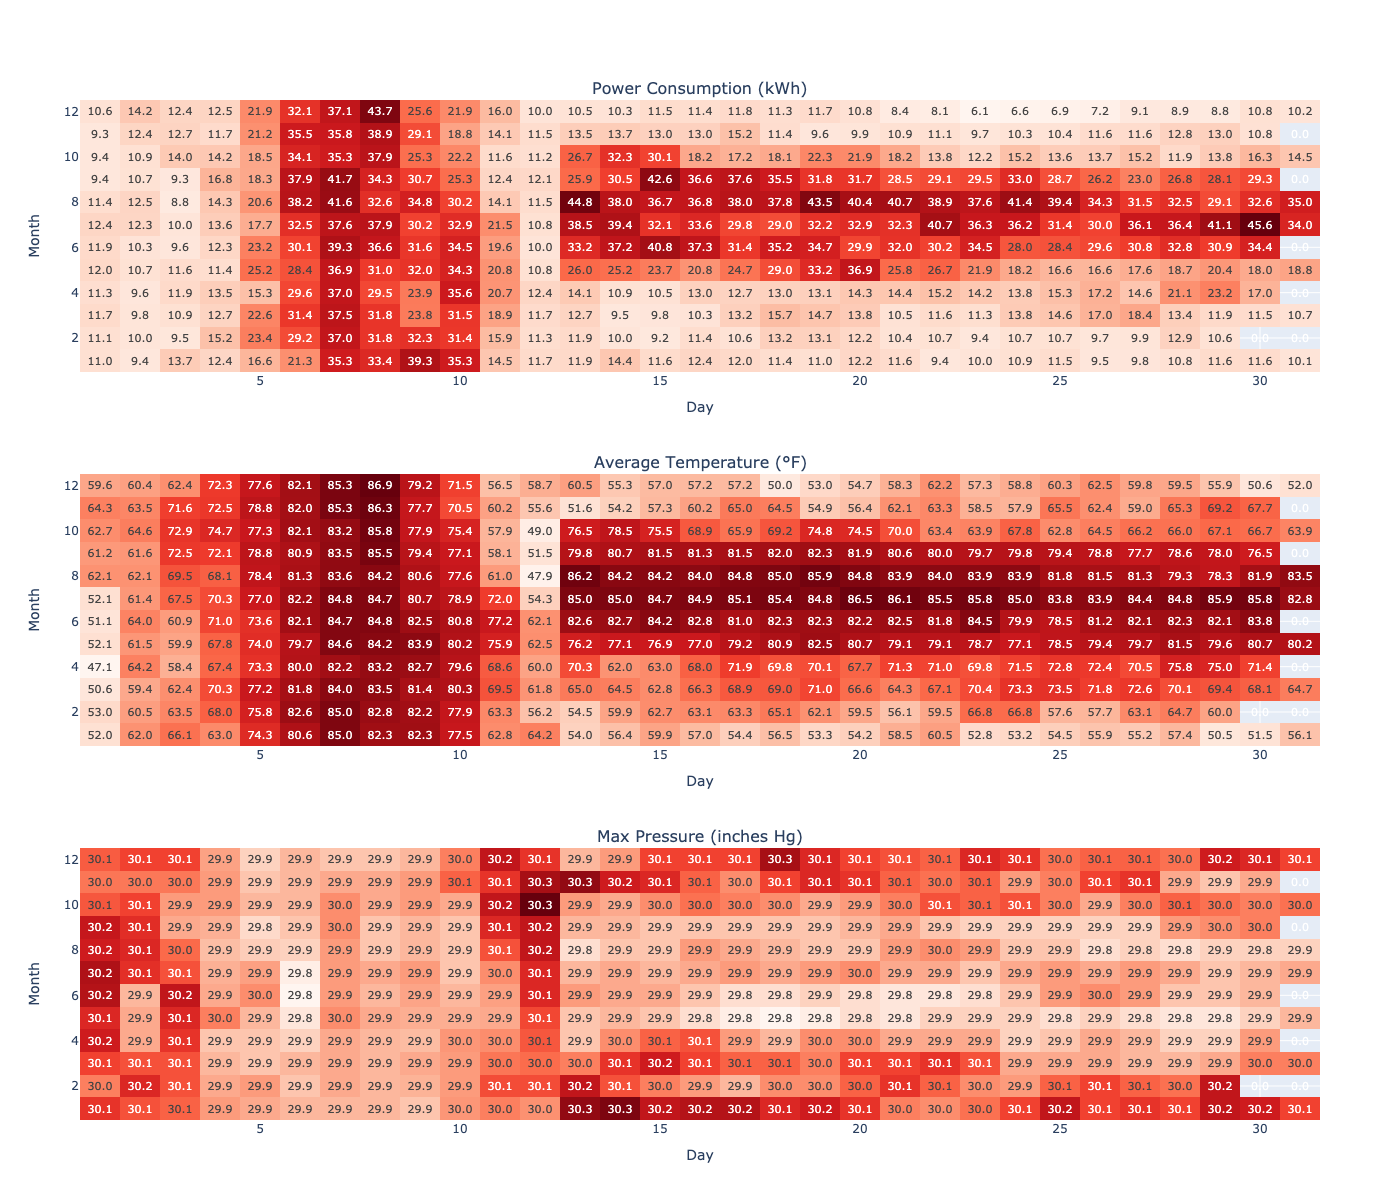

In [18]:
month_day = daily_power[["month", "power_day", "value (k_wh)"]].groupby(["month", "power_day"]).mean().unstack()

ave_temp = power_weather[["month", "day", "temp_avg"]].groupby(["month", "day"]).mean().unstack()
ave_temp.columns = [val for val in range(1,32)]

max_pressure = power_weather[["month", "day", "press_max"]].groupby(["month", "day"]).mean().unstack()
max_pressure.columns = [val for val in range(1,32)]
max_pressure


##### park this here. will come back later
# week_day = daily_power[["week", "day_name", "value (k_wh)"]].groupby(["week", "day_name"]).mean().unstack()
# week_day.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# week_day = week_day.T

fig_1a = make_subplots(rows=3, cols=1, vertical_spacing=0.1,
                       subplot_titles=["Power Consumption (kWh)", 
                                       "Average Temperature (\xb0F)", 
                                       "Max Pressure (inches Hg)"])

fig_1a.add_trace( go.Heatmap(x=[val[1] for val in month_day.columns], y=month_day.index,
                             z=month_day, text=month_day, texttemplate="%{text:.1f}", textfont={"size":11},
                             colorscale="reds"),
                             row=1, col=1)

fig_1a.add_trace( go.Heatmap(x=ave_temp.columns, y=ave_temp.index,
                             z=ave_temp, text=ave_temp, texttemplate="%{text:.1f}", textfont={"size":11},
                             colorscale="reds",),
                             row=2, col=1)

fig_1a.add_trace( go.Heatmap(x=max_pressure.columns, y=max_pressure.index,
                             z=max_pressure, text=max_pressure, texttemplate="%{text:.1f}", textfont={"size":11},
                             colorscale="reds",),
                             row=3, col=1)




fig_1a.update_xaxes(title_text="Day")
fig_1a.update_yaxes(title_text="Month")

fig_1a.update_traces(showscale=False)
fig_1a.update_layout(height=1200, width=1400)

fig_1a.show(renderer="png")

---
# Autocorrelation Plots

---

In [19]:
weather_dates = power_weather["weather_date"].to_list()

for ind, col in enumerate(power_weather_cols):

    acf_vals = acf(power_weather[col], nlags=400, missing="drop")

    if ind==0:
        df_cols = ["weather_date"]
        df_cols.append(col)
        pw_acf = pd.DataFrame(list(zip(weather_dates, acf_vals)), columns=df_cols)
    
    else:
        pw_acf[col] = acf_vals



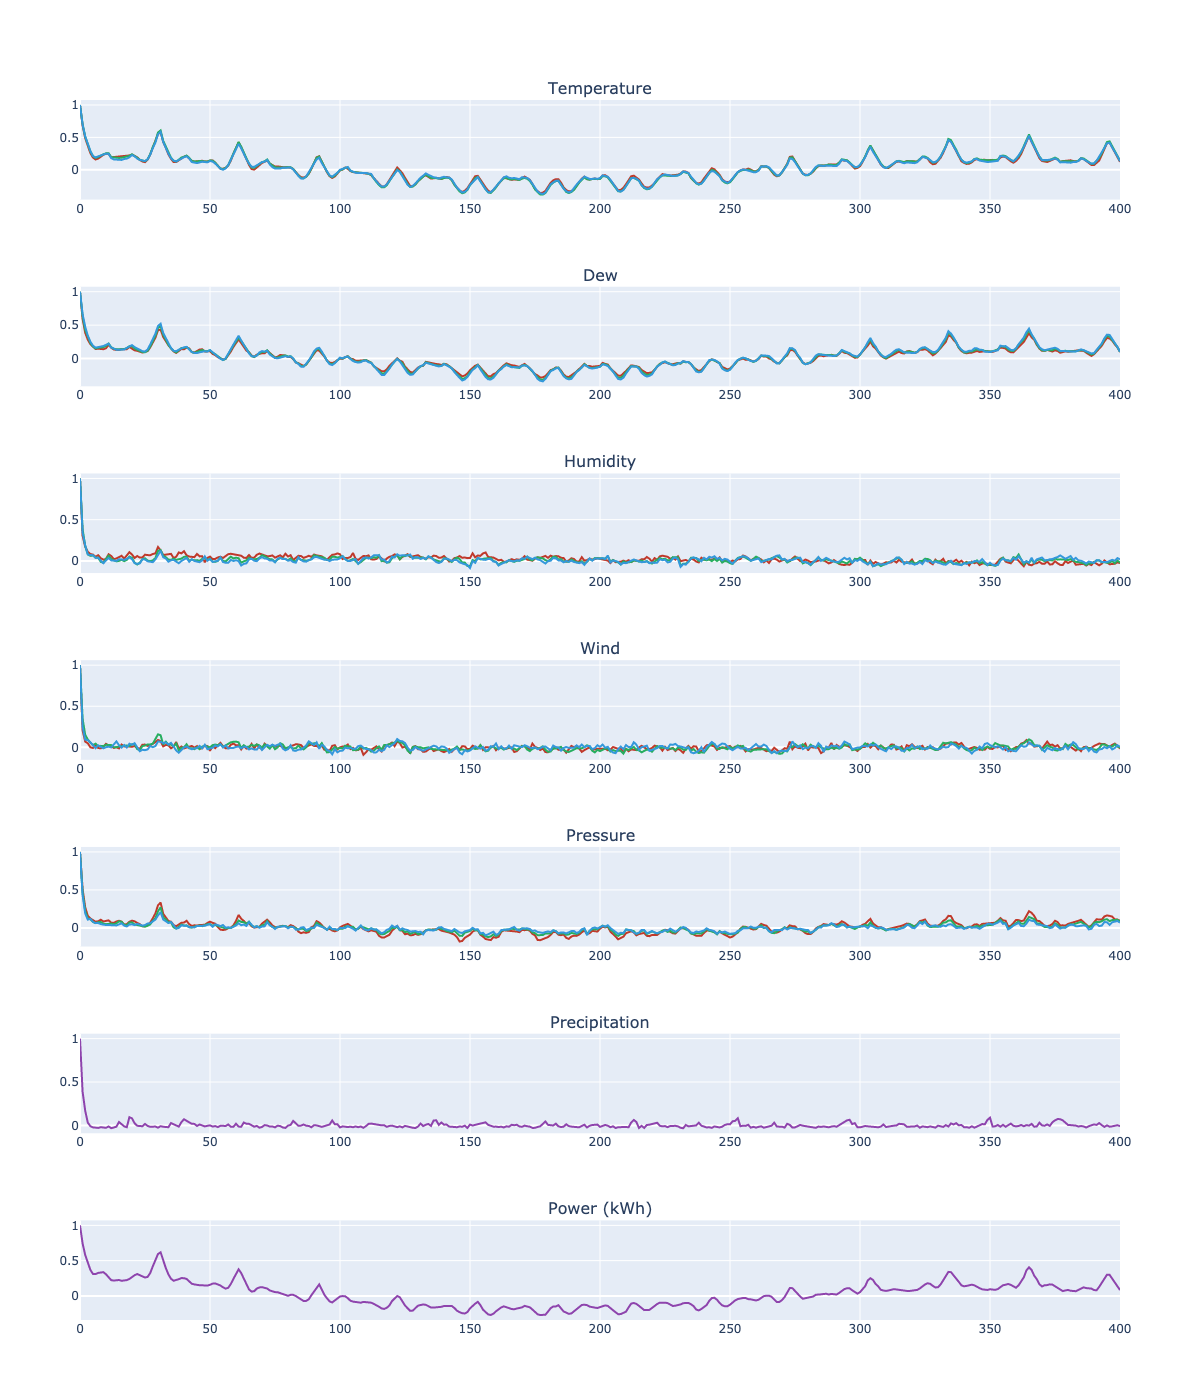

In [20]:
fig_2 = make_subplots(rows=7, cols=1, 
                      subplot_titles=["Temperature", "Dew", "Humidity", "Wind", "Pressure",
                                      "Precipitation", "Power (kWh)"])

ind = 0
col_n = ""

color_dict = {"min": "#3498DB", "avg": "#27AE60", "max": "#C0392B", "others": "#8E44AD"}


for ii in range(len(power_weather_cols)):

    col = power_weather_cols[ii]
    col_split = col.split("_")

    if (len(col_split)>1) and (col_split[1] in color_dict.keys()):
        color = color_dict[col_split[1]]
    else:
        color = color_dict["others"]


    if col_n != col_split[0]:
        col_n = col_split[0]
        ind = ind + 1

        fig_2.add_trace(
            go.Scatter(x=[val for val in range(len(pw_acf))], y=pw_acf[col], name=col,
                       line=dict(color=color)
                       ),
            row=ind,
            col=1
        )
    
    else:

        fig_2.add_trace(
            go.Scatter(x=[val for val in range(len(pw_acf))], y=pw_acf[col], name=col,
                       line=dict(color=color)
                       ),
            row=ind,
            col=1
        )


fig_2.update_layout(height=1400, width=1200, showlegend=False)
fig_2.show(renderer="png")

Humidity, Wind, Pressure, and Precipitation showed minimal autocorrelation, which tell us that the values of these variables are independent on itself. For instance, today's humidity is not dependent on yesterday's humidity value, or in another word the value for these variables occurred at random.

On the other hand, temperature, dew, and power (kWh) values have some dependent on previous values. For example, power consumption are correlated for lag at 31 days.

---
# <center> Power Consumption Forecast </center>

---


To make a forecast, the data was split into 2: training and testing set. The training set consists of data prior to 2020-01-01 and the testing set consists of data from 2020-01-01 onwards. 2 models were used to make the forecast: autoregressive and ARIMA. The accuracy of the forecasts using these models will be compared.

In [21]:
train_set = power_weather[power_weather["power_date"]<"2020-01-01"].copy()
test_set = power_weather[power_weather["power_date"]>="2020-01-01"].copy()

train_set

,weather_date,day,temp_max,temp_avg,temp_min,dew_max,dew_avg,dew_min,hum_max,hum_avg,...,press_avg,press_min,precipit,day_of_week,value (k_wh),power_date,day_name,month,week,year
177,2016-07-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016-07-01,Friday,7,26,2016
178,2016-07-02,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016-07-02,Saturday,7,26,2016
179,2016-07-03,3.0,88.0,79.600000,72.000000,72.000000,70.2,67.0,100.000000,75.20,...,29.800000,29.700000,0.00,2.0,30.322000,2016-07-03,Sunday,7,26,2016
180,2016-07-04,4.0,92.5,83.450000,76.500000,74.500000,72.7,69.5,94.000000,72.05,...,29.850000,29.750000,0.00,2.5,36.077000,2016-07-04,Monday,7,27,2016
181,2016-07-05,5.0,95.0,85.133333,77.333333,75.333333,72.8,68.0,92.666667,69.10,...,29.833333,29.733333,0.00,3.0,44.511333,2016-07-05,Tuesday,7,27,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,2019-12-27,27.0,69.0,62.400000,55.000000,62.000000,59.4,54.0,97.000000,90.00,...,29.900000,29.800000,0.00,4.0,5.173000,2019-12-27,Friday,12,52,2019
1452,2019-12-28,28.0,77.0,69.600000,63.000000,68.000000,65.0,61.0,97.000000,85.90,...,29.700000,29.600000,0.00,5.0,5.200000,2019-12-28,Saturday,12,52,2019
1453,2019-12-29,29.0,69.0,60.800000,50.000000,66.000000,51.8,36.0,97.000000,75.60,...,29.700000,29.600000,0.12,6.0,5.309000,2019-12-29,Sunday,12,52,2019
1454,2019-12-30,30.0,61.0,50.300000,39.000000,37.000000,31.0,26.0,89.000000,51.80,...,30.000000,29.900000,0.71,0.0,4.947000,2019-12-30,Monday,12,1,2019


In [22]:
autoreg = AutoReg(train_set[["value (k_wh)", "power_date"]].set_index("power_date")
                  , lags=[val for val in range(1,71) if val%7], missing="drop"
                  , seasonal=True
                  , trend="t").fit()

autoreg_fitted = autoreg.predict(start="2016-07-03", end="2019-12-31")
autoreg_fitted = autoreg_fitted.to_frame().rename(columns={0:"fitted"})
autoreg_fitted["actual"] = train_set[["power_date", "value (k_wh)"]].set_index("power_date")
autoreg_fitted["residual"] = autoreg_fitted["fitted"] - autoreg_fitted["actual"]

autoreg_predict = autoreg.predict(start="2020-01-01", end="2020-06-30")
autoreg_predict = autoreg_predict.to_frame().rename(columns={0:"predicted"})
autoreg_predict["actual"] = test_set[["power_date", "value (k_wh)"]].set_index("power_date")
autoreg_predict["error"] = autoreg_predict["predicted"] - autoreg_predict["actual"]
autoreg_predict["squared_error"] = autoreg_predict["error"]**2
autoreg_predict["percent_error"] = autoreg_predict["error"]*100/autoreg_predict["actual"]
autoreg_stddev = stat.stdev(autoreg_predict["error"])
autoreg_predict["low_95"] = autoreg_predict["predicted"] - 1.96*autoreg_stddev
autoreg_predict["high_95"] = autoreg_predict["predicted"] + 1.96*autoreg_stddev

autoreg_fitted

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/deterministic.py:435: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



,fitted,actual,residual
2016-07-03,NaN,30.322000,NaN
2016-07-04,NaN,36.077000,NaN
2016-07-05,NaN,44.511333,NaN
2016-07-06,NaN,30.322000,NaN
2016-07-07,NaN,41.832000,NaN
...,...,...,...
2019-12-27,8.818609,5.173000,3.645609
2019-12-28,10.783793,5.200000,5.583793
2019-12-29,9.972066,5.309000,4.663066
2019-12-30,7.580477,4.947000,2.633477


In [23]:
arima = ARIMA(train_set[["value (k_wh)", "power_date"]].set_index("power_date")
              , order=(30, 1, 1)
              , missing="drop").fit()

arima_fitted = arima.predict(start="2016-07-03", end="2019-12-31")
arima_fitted = arima_fitted.to_frame()#.rename(columns={0:"predicted"})
arima_fitted["actual"] = train_set[["power_date", "value (k_wh)"]].set_index("power_date")
arima_fitted["residual"] = arima_fitted["predicted_mean"] - arima_fitted["actual"]

arima_predict = arima.predict(start="2020-01-01", end="2020-06-30")
arima_predict = arima_predict.to_frame()#.rename(columns={0:"predicted"})
arima_predict["actual"] = test_set[["power_date", "value (k_wh)"]].set_index("power_date")
arima_predict["error"] = arima_predict["predicted_mean"] - arima_predict["actual"]
arima_predict["squared_error"] = arima_predict["error"]**2
arima_predict["percent_error"] = arima_predict["error"]*100/arima_predict["actual"]
arima_stddev = stat.stdev(arima_predict["error"])
arima_predict["low_95"] = arima_predict["predicted_mean"] - 1.96*arima_stddev
arima_predict["high_95"] = arima_predict["predicted_mean"] + 1.96*arima_stddev


arima_fitted

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,predicted_mean,actual,residual
2016-07-03,0.000000,30.322000,-30.322000
2016-07-04,30.321144,36.077000,-5.755856
2016-07-05,35.046996,44.511333,-9.464338
2016-07-06,42.008130,30.322000,11.686130
2016-07-07,31.499036,41.832000,-10.332964
...,...,...,...
2019-12-27,8.410602,5.173000,3.237602
2019-12-28,9.782582,5.200000,4.582582
2019-12-29,9.198604,5.309000,3.889604
2019-12-30,8.281821,4.947000,3.334821


---
# Residual Diagnostic on Training Set

---

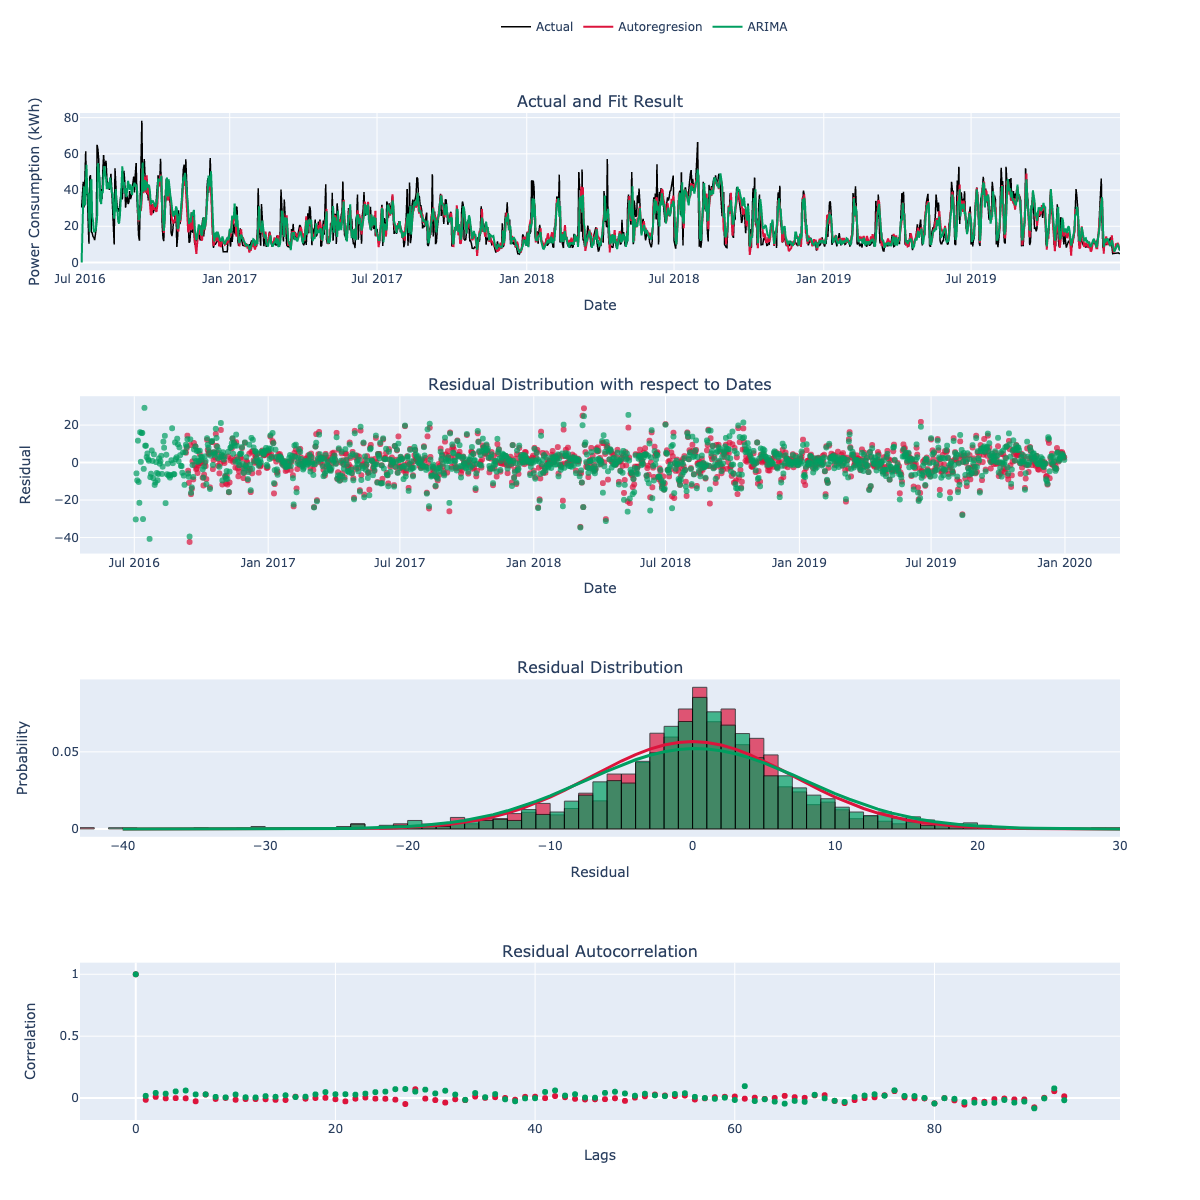

In [24]:
fig = make_subplots(rows=4, cols=1,
                    subplot_titles=["Actual and Fit Result", "Residual Distribution with respect to Dates",
                                    "Residual Distribution", "Residual Autocorrelation"])

diff_models = [go.Scatter(x=train_set["power_date"], y=train_set["value (k_wh)"], line=dict(color="black", width=1.5)
                          , showlegend=True, legendgroup="Actual", name="Actual")
                , go.Scatter(x=autoreg_fitted.index, y=autoreg_fitted["fitted"], line=dict(color="#DC143C")
                             , showlegend=True, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=arima_fitted.index, y=arima_fitted["predicted_mean"], line=dict(color="#009E60")
                             , showlegend=True, legendgroup="ARIMA", name="ARIMA")
                ]

residual_dist = [go.Scatter(x=autoreg_fitted.index, y=autoreg_fitted["residual"], mode="markers", marker=dict(color="#DC143C", opacity=0.7)
                    , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=arima_fitted.index, y=arima_fitted["residual"], mode="markers", marker=dict(color="#009E60", opacity=0.7)
                              , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                 ]

residual_dist_2 = [ go.Histogram(x=autoreg_fitted["residual"], histnorm="probability"
                                 , marker=dict(color="#DC143C", line_width=1, line_color="black", opacity=0.7)
                                , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                    , go.Histogram(x=arima_fitted["residual"], histnorm="probability"
                                , marker=dict(color="#009E60", line_width=1, line_color="black", opacity=0.7)
                                , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                    ]

autoreg_fitted_acf = acf(autoreg_fitted["residual"].dropna(), nlags=93)
arima_fitted_acf = acf(arima_fitted["residual"], nlags=93)
lags = [val for val in range(len(arima_fitted_acf))]

acf_traces = [ go.Scatter(x=lags, y=autoreg_fitted_acf
                             , mode="markers", marker=dict(color="#DC143C")
                             , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=lags, y=arima_fitted_acf
                             , mode="markers", marker=dict(color="#009E60")
                             , showlegend=False, legendgroup="ARIMA", name="ARIMA")]


autoreg_dist = norm(stat.mean(autoreg_fitted["residual"].dropna().values), stat.stdev(autoreg_fitted["residual"].dropna().values))
arima_dist = norm(stat.mean(arima_fitted["residual"]), stat.stdev(arima_fitted["residual"]))

dist_vals = [val for val in range(-40, 31)]
autoreg_probs = [autoreg_dist.pdf(value) for value in dist_vals]
arima_probs = [arima_dist.pdf(value) for value in dist_vals]

fitted_dist = [go.Scatter(x=dist_vals, y=autoreg_probs
                             , mode="lines", line=dict(color="#DC143C", width=3)
                             , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=dist_vals, y=arima_probs
                             , mode="lines", line=dict(color="#009E60", width=3)
                             , showlegend=False, legendgroup="ARIMA", name="ARIMA")]


for model in diff_models:
    fig.add_trace(model, row=1, col=1)

for dist in residual_dist:
    fig.add_trace(dist, row=2, col=1)

for dist_2 in residual_dist_2:
    fig.add_trace(dist_2, row=3, col=1)

for dist_3 in fitted_dist:
    fig.add_trace(dist_3, row=3, col=1)

for acf_val in acf_traces:
    fig.add_trace(acf_val, row=4, col=1)

xaxes = ["Date", "Date", "Residual", "Lags"]
yaxes = ["Power Consumption (kWh)", "Residual", "Probability", "Correlation"]

for num, xlabel in enumerate(xaxes):
    fig.update_xaxes(title_text=xlabel, row=num+1)

for num, ylabel in enumerate(yaxes):
    fig.update_yaxes(title_text=ylabel, row=num+1)


fig.update_layout(height=1200, width=1200, legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.4, orientation="h"), barmode="overlay")

fig.show(renderer="png")

The top most plot shows how the actual power consumption data and fitted data using autoregressive and ARIMA model. The fitted data fits nicely to the actual data. 

The second plot from the top shows the residual distribution of the model with respect to dates. Overall, the residuals centered around zero and no pattern can be observed from this distribution.

The third plot shows the residual plot probability distribution. The solid red and green lines are the fitted normal pdf for autoregressive model and arima model, respectively. In both cases, the residuals were normally distributed.

The final plot shows the residual autocorrelation for both models. This plot shows that the correlation drops to almost zero starting from lag = 1 indicating that the residuals are random for both models.



---
# Forecast Plots

---

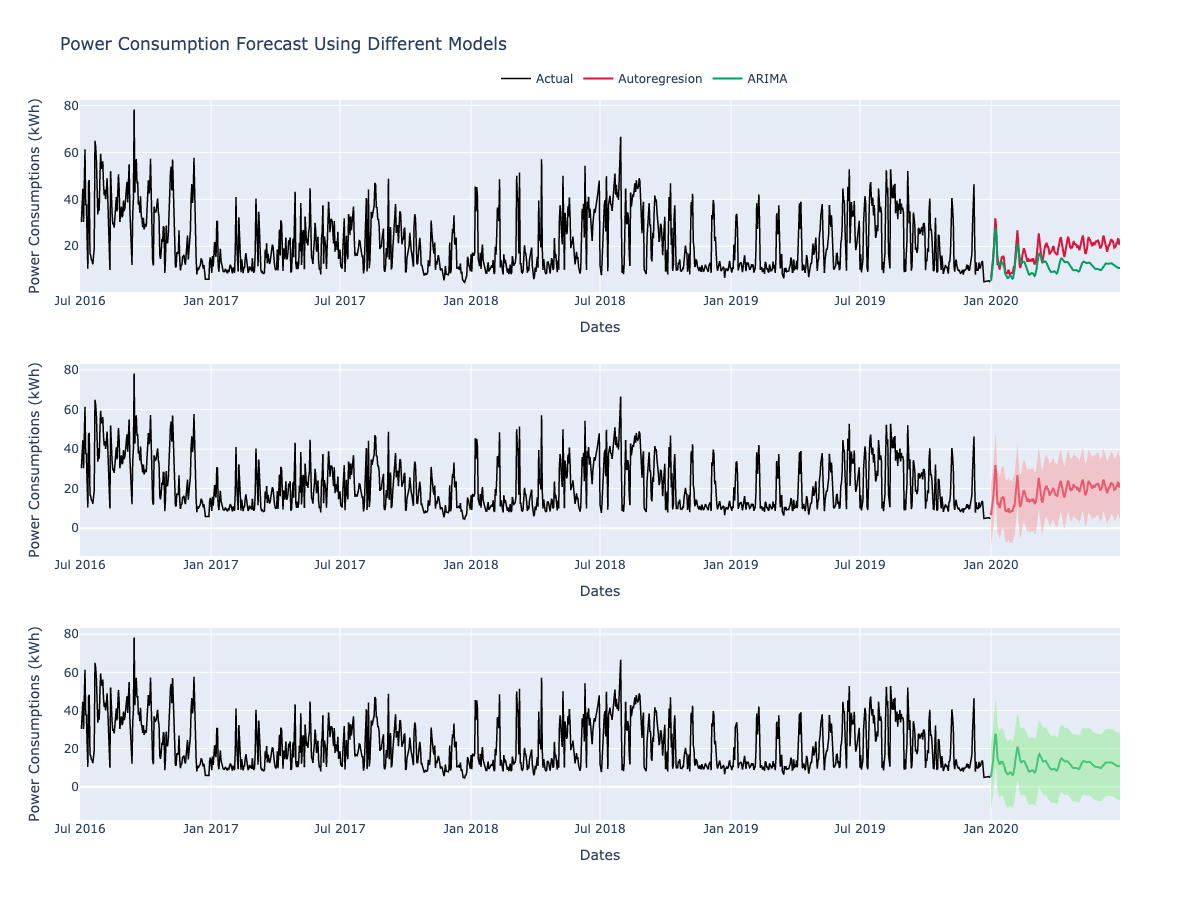

In [25]:
fig = make_subplots(rows=3, cols=1)

diff_models = [go.Scatter(x=train_set["power_date"], y=train_set["value (k_wh)"], line=dict(color="black", width=1.5)
                          , showlegend=True, legendgroup="Actual", name="Actual")
                , go.Scatter(x=autoreg_predict.index, y=autoreg_predict["predicted"], line=dict(color="#DC143C")
                             , showlegend=True, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=arima_predict.index, y=arima_predict["predicted_mean"], line=dict(color="#009E60")
                             , showlegend=True, legendgroup="ARIMA", name="ARIMA")
                ]

autoreg_traces = [go.Scatter(x=train_set["power_date"], y=train_set["value (k_wh)"], line=dict(color="black", width=1.5)
                             , showlegend=False, legendgroup="Actual", name="Actual")
                 , go.Scatter(x=autoreg_predict.index, y=autoreg_predict["predicted"], line=dict(color="#DC143C")
                              , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                 , go.Scatter(x=autoreg_predict.index, y=autoreg_predict["high_95"], line=dict(color="#FAA0A0", width=0)
                              , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                 , go.Scatter(x=autoreg_predict.index, y=autoreg_predict["low_95"], line=dict(color="#FAA0A0", width=0), fill="tonexty"
                              , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                 ]

arima_traces = [go.Scatter(x=train_set["power_date"], y=train_set["value (k_wh)"], line=dict(color="black", width=1.5)
                           , showlegend=False, legendgroup="Actual", name="Actual")
                 , go.Scatter(x=arima_predict.index, y=arima_predict["predicted_mean"], line=dict(color="#009E60")
                              , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                 , go.Scatter(x=arima_predict.index, y=arima_predict["high_95"], line=dict(color="#90EE90", width=0)
                              , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                 , go.Scatter(x=arima_predict.index, y=arima_predict["low_95"], line=dict(color="#90EE90", width=0), fill="tonexty"
                              , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                 ]

for model in diff_models:
    fig.add_trace(model, row=1, col=1)

for autoreg_trace in autoreg_traces:
    fig.add_trace(autoreg_trace, row=2, col=1)

for arima_trace in arima_traces:
    fig.add_trace(arima_trace, row=3, col=1)

fig.update_xaxes(title_text="Dates")
fig.update_yaxes(title_text="Power Consumptions (kWh)")
fig.update_layout(height=900, width=1200, legend=dict(yanchor="top", y=1.05, xanchor="left", x=0.4, orientation="h"),
                  title='Power Consumption Forecast Using Different Models')


fig.show(renderer="png")

The above plots shows the forecasted values from 2020-01-01. The first plot shows the forecast generated by different models: autoregressive (red) and ARIMA (green). The second and third plot show each plot with its prediction interval at 95% intervals.

The table below shows the accuracy as measured by 3 different metrics: mean absolute error (mae), root mean square error (rmse), and mean absolute percentage error (mape). Autoregressive model performs better 2/3 of the time relative to arima model.

In [26]:
autoreg_mae = stat.mean(abs(autoreg_predict["error"]))
autoreg_mse = stat.sqrt(stat.mean(autoreg_predict["squared_error"]))
autoreg_mape = stat.mean(abs(autoreg_predict["percent_error"]))

arima_mae = stat.mean(abs(arima_predict["error"]))
arima_mse = stat.sqrt(stat.mean(arima_predict["squared_error"]))
arima_mape = stat.mean(abs(arima_predict["percent_error"]))

summary_ind = ["autoregressive", "arima"]
summary_col = ["mae", "rmse", "mape"]

maes = [autoreg_mae, arima_mae]
mses = [autoreg_mse, arima_mse]
mapes = [autoreg_mape, arima_mape]

mdl_acc = pd.DataFrame(list(zip(maes, mses, mapes)), index=summary_ind, columns=summary_col)

mdl_acc

,mae,rmse,mape
autoregressive,6.561896,8.084728,39.019322
arima,8.477119,11.561713,36.780657


---
# Residual Diagnostic for Testing Set

---
The residual diagnostic for testing set and improving the forecasting ability will be left for future work.

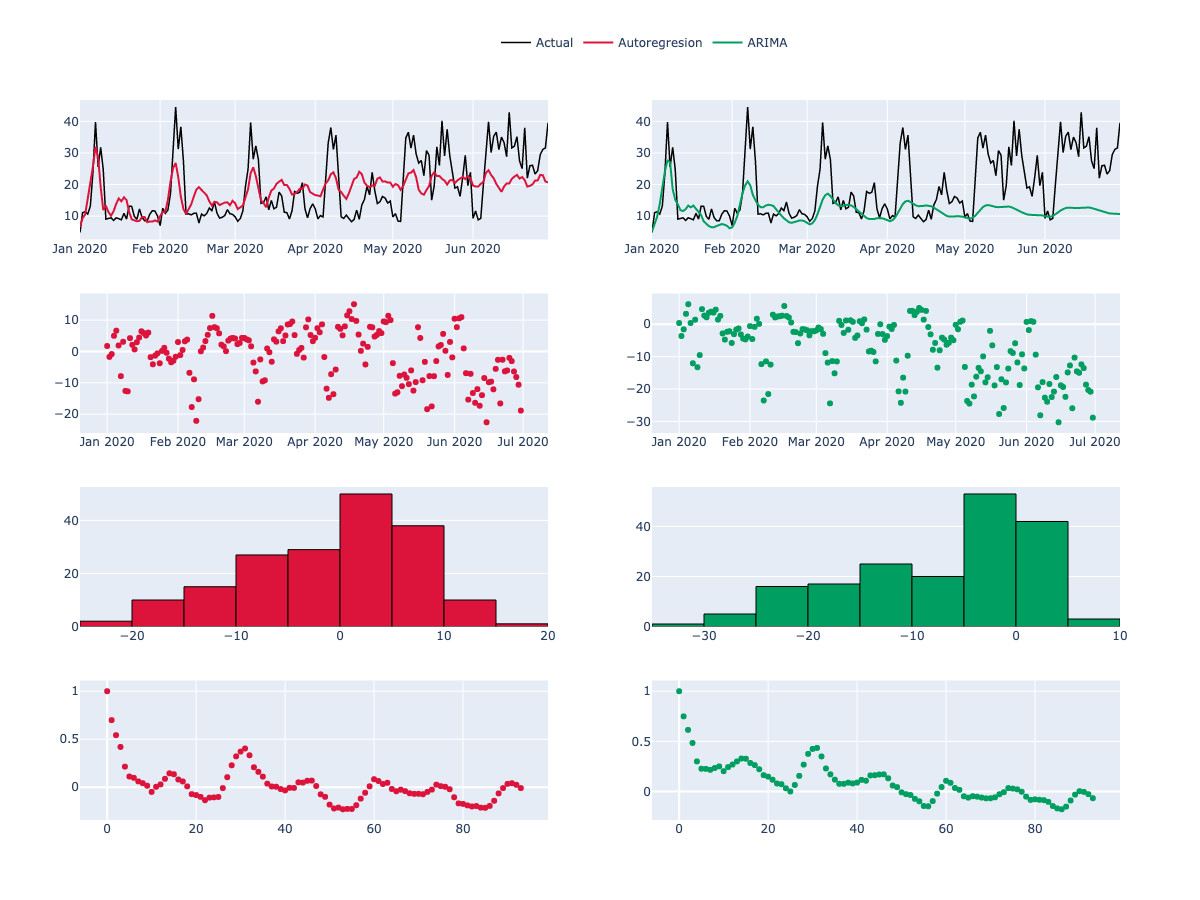

In [27]:
fig = make_subplots(rows=4, cols=2)

autoreg_acf = acf(autoreg_predict["error"], nlags=93)
arima_acf = acf(arima_predict["error"], nlags=93)
lags = [val for val in range(len(arima_acf))]


plot_trace = [ go.Scatter(x=test_set["power_date"], y=test_set["value (k_wh)"], line=dict(color="black", width=1.5)
                           , showlegend=True, legendgroup="Actual", name="Actual")
                , go.Scatter(x=test_set["power_date"], y=test_set["value (k_wh)"], line=dict(color="black", width=1.5)
                           , showlegend=False, legendgroup="Actual", name="Actual")
                , go.Scatter(x=autoreg_predict.index, y=autoreg_predict["predicted"], line=dict(color="#DC143C")
                              , showlegend=True, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=arima_predict.index, y=arima_predict["predicted_mean"], line=dict(color="#009E60")
                              , showlegend=True, legendgroup="ARIMA", name="ARIMA")]

residual_dist = [ go.Scatter(x=autoreg_predict.index, y=autoreg_predict["error"]
                             , mode="markers", marker=dict(color="#DC143C")
                             , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=arima_predict.index, y=arima_predict["error"]
                             , mode="markers", marker=dict(color="#009E60")
                             , showlegend=False, legendgroup="ARIMA", name="ARIMA")]

residual_dist_2 = [ go.Histogram(x=autoreg_predict["error"], marker=dict(color="#DC143C", line_width=1, line_color="black")
                                , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                    , go.Histogram(x=arima_predict["error"], marker=dict(color="#009E60", line_width=1, line_color="black")
                                , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                    ]

acf_traces = [ go.Scatter(x=lags, y=autoreg_acf
                             , mode="markers", marker=dict(color="#DC143C")
                             , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=lags, y=arima_acf
                             , mode="markers", marker=dict(color="#009E60")
                             , showlegend=False, legendgroup="ARIMA", name="ARIMA")]

for num, md in enumerate(plot_trace):
    fig.add_trace(md, row=1, col=num%2+1)

for num, md in enumerate(residual_dist):
    fig.add_trace(md, row=2, col=num%2+1)

for num, md in enumerate(residual_dist_2):
    fig.add_trace(md, row=3, col=num%2+1)

for num, md in enumerate(acf_traces):
    fig.add_trace(md, row=4, col=num%2+1)


fig.update_layout(height=900, width=1200, legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.4, orientation="h"))

fig.show(renderer="png")